# Deep Depth Densification (D3)

In [1]:
import tensorflow as tf
import numpy as np

## Dataset

## Input depth sampling

In [9]:
# I assume an input RGB image
w, h = 640, 480

# raw images
I = None  # RGB image
D = None  # ground truth depth map. invalid pixels are zero.
M = None  # mask image, sensor sparse depth location

# preprocessed input images
S1 = None  # sparse depth map
S2 = None  # distance transform


def euclidean_traversal(image, pixel, cond):
    """Traversal image to find the closest pixel from starting point that satisfy a condition.
    The search always starts at the next closest (in Hamming distance) in the NE, SE, NW, SW directions.
    And search along the four edges of a diamond.
    
    image: numpy array
    pixel: (x, y) tuple
    cond: a function that operates on image(x, y) and returns True or False
    """
    if not isinstance(image, np.ndarray):
        raise RuntimeError("D3::euclidean_traversal::image is not a numpy array.")
    if len(pixel) != 2:
        raise RuntimeError("D3::euclidean_traversal::pixel is not a 2 element list or tuple.")
    w, h = image.shape[0], image.shape[1]
    max_d_ham = max([pixel[0] + pixel[1], w - pixel[0] - 1 + pixel[1],
                    pixel[0] + h - pixel[1] - 1, w - pixel[0] + h - pixel[1] - 2])
    d_ham = 1  # hamming distance
    while d_ham <= max_d_ham:
        diff = 0.5 if d_ham % 2 == 1 else 0.0
        while diff < d_ham / 2 + 0.1:  # search along the edge of the diamond, starting from center of the edge
            for radx, rady in [(1, 1), (1, -1), (-1, 1), (-1, -1)]:  # the diamond has four edges
                for tanx in [1, -1]:  # symmetrically search in both directions
                    tany = - tanx * radx / rady
                    x = pixel[0] + round((d_ham / 2) * radx + diff * tanx)
                    y = pixel[1] + round((d_ham / 2) * rady + diff * tany)
                    if x >= 0 and x < w and y >= 0 and y < h and cond(image[x, y]):
                        return (x, y)
            diff += 1.0
        d_ham += 1
    return (-1, -1)


def correct_depth_and_sampling_maps(D, M):
    """For any pixel p in D and M, if D(p) == 0 and M(p) == 1, then find the nearest pixel p' and assign
    M(p) = 0 and M(p') = 1.
    """
    if M.shape != D.shape:
        raise RuntimeError("D3::correct_depth_and_sampling_maps::sampling map dimension does not map depth map.")
    h, w = M.shape
    for r in range(h):
        for c in range(w):
            if M[r, c] == 1 and D[r, c] == 0:
                p = euclidean_traversal(D, (r, c), lambda x : x > 0)
                if p == (-1, -1):
                    raise RuntimeError("D3::correct_depth_and_sampling_maps::failed to find nearest valid depth.")
                M[r, c] = 0
                M[p[0], p[1]] = 1


from collections import deque

def euclidean_distance_transform(M):
    """Assumes that M is an mask image where M(x, y) == 1 means a point of interest, M(x, y) == 0 otherwise.
    This is a multi-entry Breadth-First-Search (BSF) algo.
    
    Return:
        dist: distance map
        
        orig: the nearest pixel map
    """
    h, w = M.shape[0], M.shape[1]
    orig = np.ones((h, w, 2)) * (-1)  # the closest interest point.
    nexts = deque()
    for r in range(h):
        for c in range(w):
            if M[r, c] == 1:
                nexts.append(([r, c], [r, c]))  # next pixel and its potential nearest neighbor
    while len(nexts) > 0:
        n = nexts[0]
        r, c = n[0]
        r0, c0 = n[1]
        r1, c1 = orig[r, c]
        if [r1, c1] == [-1, -1] or np.linalg.norm([r - r1, c - c1]) > np.linalg.norm([r - r0, c - c0]):
            orig[r, c] = [r0, c0]
            dirs = [(0, 1), (1, 0), (-1, 0), (0, -1)]
            for d in dirs:
                rn, cn = r + d[0], c + d[1]
                if rn >= 0 and rn < h and cn >= 0 and cn < w and np.any(orig[rn, cn] != [r0, c0]):
                    nexts.append(([rn, cn], [r0, c0]))
        nexts.popleft()
    dist = np.zeros((h, w))
    for r in range(h):
        for c in range(w):
            r0, c0 = orig[r, c]
            dist[r, c] = np.linalg.norm([r - r0, c - c0])
    return dist, orig
                    
    
def compute_nearest_neighbor_depth(M, D):
    """Generate a depth map that has the same dimension as the input depth map D. Each pixel in the depth map
    contains the depth of the nearest valid point in the sampling map M. M(x, y) == 1 means a pixel to sample.
    
    Note: this function assumes all D's pixels are valid, i.e. has positive depth values.
    """
    if M.shape != D.shape:
        raise RuntimeError("D3::compute_nearest_neighbor_depth::sampling map dimension does not map depth map.")
    h, w = M.shape[0], M.shape[1]
    # get the nearest pixel map 'orig'
    d, orig = euclidean_distance_transform(M)
    dmap = np.zeros((h, w))
    for r in range(h):
        for c in range(w):
            r0, c0 = orig[r, c]
            dmap[r, c] = D[r0, c0]
    return dmap


def preprocess(I, D, M):
    h, w = I.shape[0], I.shape[1]
    if I.shape[2] != 3 or D.shape != (h, w) or M.shape != (h, w):
        raise RuntimeError("D3::preprocess::Raw input images have wrong shapes.")
    correct_depth_and_sampling_maps(D, M)
    S1 = compute_nearest_neighbor_depth(M, D)
    S2 = euclidean_distance_transform(M)
    return np.dstack([S1, S2])



In [5]:
M = np.zeros((20, 20))
for r in range(0, 20, 4):
    for c in range(0, 20, 4):
        M[r, c] = 1
d, _ = euclidean_distance_transform(M)

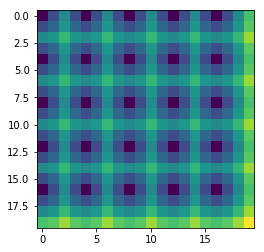

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(d)

In [10]:
D = np.ones((6, 5))
M = np.zeros((6, 5))
D[2, 3] = 0
D[2, 4] = 0
D[3, 3] = 0
D[1, 3] = 0
D[2, 2] = 0
M[2, 3] = 1

print(D)
print(M)
correct_depth_and_sampling_maps(D, M)
print(D)
print(M)

[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.]
 [ 1.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.]
 [ 1.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
